In [ ]:
# =========================
# ETAPE 1 — Chargement NAB + labels point-par-point + standardisation (sur normal)
# =========================
import pandas as pd, numpy as np, requests
from sklearn.preprocessing import StandardScaler


category = "realTweets"
fname    = "Twitter_volume_AMZN.csv"

# 1) Charger la série depuis GitHub
raw_csv = f"https://raw.githubusercontent.com/numenta/NAB/master/data/{category}/{fname}"
df = pd.read_csv(raw_csv)

time_candidates  = [c for c in df.columns if "time" in c.lower() or "date" in c.lower()]
if not time_candidates:
    raise ValueError("Impossible de trouver la colonne temps (contient 'time' ou 'date').")
TIME_COL = time_candidates[0]
value_candidates = [c for c in df.columns if c != TIME_COL and df[c].dtype != "object"]
if not value_candidates:
    for c in df.columns:
        if c != TIME_COL:
            df[c] = pd.to_numeric(df[c], errors="coerce")
            if df[c].notna().any():
                value_candidates = [c]; break
if not value_candidates:
    raise ValueError("Impossible de trouver la colonne valeur.")
VALUE_COL = value_candidates[0]

df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df = df[[TIME_COL, VALUE_COL]].dropna().sort_values(TIME_COL).reset_index(drop=True)

# 2) Charger les fenêtres d'anomalies (ground-truth NAB)
labels_url = "https://raw.githubusercontent.com/numenta/NAB/master/labels/combined_windows.json"
windows = requests.get(labels_url).json()
key = f"{category}/{fname}"
win_list = windows.get(key, [])

ts = df[TIME_COL].to_numpy()
labels_points = np.zeros(len(df), dtype=bool)

for w in win_list:
    if isinstance(w, dict):
        s = pd.to_datetime(w["start"]); e = pd.to_datetime(w["end"])
    elif isinstance(w, (list, tuple)) and len(w) >= 2:
        s = pd.to_datetime(w[0]); e = pd.to_datetime(w[1])
    else:
        continue
    labels_points |= (ts >= s) & (ts <= e)

df["label"] = labels_points.astype(int)

# 4) Standardiser uniquement sur le normal (label==0)
scaler = StandardScaler().fit(df.loc[df["label"]==0, [VALUE_COL]])
df["x"] = scaler.transform(df[[VALUE_COL]])

n_total = len(df)
n_anom  = int(df["label"].sum())
print(f"Série chargée: {key}")
print(f"Période: {df[TIME_COL].min()} -> {df[TIME_COL].max()} | n={n_total}")
print(f"Fenêtres NAB: {len(win_list)} | Points anormaux (NAB): {n_anom}")
display(df.head())

Série chargée: realTweets/Twitter_volume_AMZN.csv
Période: 2015-02-26 21:42:53 -> 2015-04-22 20:52:53 | n=15831
Fenêtres NAB: 4 | Points anormaux (NAB): 1580


,timestamp,value,label,x
0,2015-02-26 21:42:53,57,0,0.194765
1,2015-02-26 21:47:53,43,0,-0.370686
2,2015-02-26 21:52:53,55,0,0.113986
3,2015-02-26 21:57:53,64,0,0.477491
4,2015-02-26 22:02:53,93,0,1.648783


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# reshape pour scaler : (N, 1)
values = df["value"].values.reshape(-1, 1)

values_scaled = scaler.fit_transform(values)

df["value_scaled"] = values_scaled

In [ ]:
signal = df["value_scaled"].values

In [ ]:
# =========================
# ETAPE 2 — Fenêtrage + masques (normal vs touche anomalie)
# =========================
import numpy as np
import pandas as pd

SEQ_LEN = 15

def to_windows(series: pd.Series, seq_len: int):
    X = []
    for i in range(len(series) - seq_len):
        X.append(series.iloc[i:i+seq_len].values.reshape(seq_len, 1))
    return np.array(X)

X_all = to_windows(df["x"], SEQ_LEN)

dates_all = df[TIME_COL].iloc[SEQ_LEN:].reset_index(drop=True)

labels_points = df["label"].astype(bool).to_numpy()
win_is_anom = np.array([
    labels_points[i:i+SEQ_LEN].any()
    for i in range(len(labels_points) - SEQ_LEN)
], dtype=bool)

idx_norm = ~win_is_anom
X_train  = X_all[idx_norm]
n_all, n_norm, n_anom = len(X_all), int(idx_norm.sum()), int((~idx_norm).sum())

print(f"Fenêtres totales : {n_all}")
print(f"   ↳ 100% normales (train) : {n_norm}")
print(f"   ↳ touchent une anomalie : {n_anom}")

print("\nVérifs de shapes :")
print("X_all :", X_all.shape, "| X_train :", X_train.shape, "| dates_all :", dates_all.shape)

Fenêtres totales : 15816
   ↳ 100% normales (train) : 14180
   ↳ touchent une anomalie : 1636

Vérifs de shapes :
X_all : (15816, 15, 1) | X_train : (14180, 15, 1) | dates_all : (15816,)


In [ ]:
import requests, pandas as pd

def load_anomaly_windows_for(series_relpath: str):
    """
    Retourne [(start_ts, end_ts), ...] pour une série NAB donnée,
    en gérant les items au format dict {"start","end"} OU liste ["start","end"].
    """
    labels_url = "https://raw.githubusercontent.com/numenta/NAB/master/labels/combined_windows.json"
    windows = requests.get(labels_url).json()
    raw_list = windows.get(series_relpath, [])
    out = []
    for w in raw_list:
        if isinstance(w, dict) and "start" in w and "end" in w:
            s = pd.to_datetime(w["start"]); e = pd.to_datetime(w["end"])
        elif isinstance(w, (list, tuple)) and len(w) >= 2:
            s = pd.to_datetime(w[0]); e = pd.to_datetime(w[1])
        else:
            continue
        if e < s:
            s, e = e, s
        out.append((s, e))
    return out

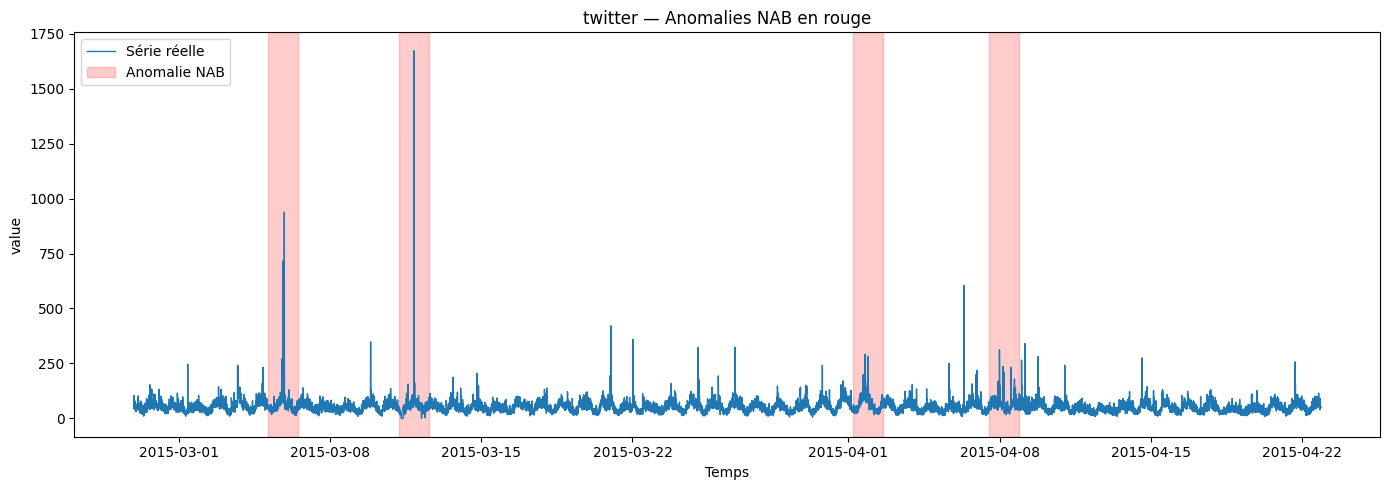

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

true_ints = load_anomaly_windows_for(
    "realTweets/Twitter_volume_AMZN.csv"
)

plt.figure(figsize=(14, 5))
ts = df[TIME_COL]
vals = df[VALUE_COL]

plt.plot(ts, vals, lw=1, label="Série réelle")

first = True
for start, end in true_ints:
    plt.axvspan(start, end,
                color="red", alpha=0.2,
                label="Anomalie NAB" if first else None)
    first = False

plt.title("twitter — Anomalies NAB en rouge")
plt.xlabel("Temps")
plt.ylabel(VALUE_COL)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
# ====================================
# ETAPE 3 — CNN 1D Autoencodeur (SEQ_LEN = 15)
# ====================================
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Dropout
from tensorflow.keras import regularizers

reg_l2 = 1e-5
drop   = 0.3

inputs = Input(shape=(SEQ_LEN, 1))

# ---- ENCODEUR ----
x = Conv1D(
    filters=32,
    kernel_size=3,
    activation="relu",
    padding="same",
    kernel_regularizer=regularizers.l2(reg_l2)
)(inputs)

# COMPRESSION : 15 -> 5
x = MaxPooling1D(pool_size=3, padding="same")(x)
x = Dropout(drop)(x)

x = Conv1D(
    filters=16,
    kernel_size=3,
    activation="relu",
    padding="same",
    kernel_regularizer=regularizers.l2(reg_l2)
)(x)
x = Dropout(drop)(x)

# ---- BOTTLENECK ----
bottleneck = Conv1D(
    filters=8,
    kernel_size=3,
    activation="relu",
    padding="same",
    kernel_regularizer=regularizers.l2(reg_l2),
    name="bottleneck_cnn"
)(x)

# ---- DECODEUR ----
# DÉCOMPRESSION : 5 -> 15
x = UpSampling1D(size=3)(bottleneck)

x = Conv1D(
    filters=16,
    kernel_size=3,
    activation="relu",
    padding="same",
    kernel_regularizer=regularizers.l2(reg_l2)
)(x)
x = Dropout(drop)(x)

outputs = Conv1D(
    filters=1,
    kernel_size=3,
    activation="linear",
    padding="same"
)(x)  # -> (None, 15, 1)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mae")

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 15, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 15, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 5, 16)          │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck_cnn (Conv1D)         │ (None, 5, 8)           │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 15, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 15, 16)         │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 15, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 15, 1)          │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,521 (9.85 KB)

 Trainable params: 2,521 (9.85 KB)

 Non-trainable params: 0 (0.00 B)

Entraînement sur 12762 fenêtres, validation sur 1418.
Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.5206 - val_loss: 0.3098
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3804 - val_loss: 0.2875
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3619 - val_loss: 0.2793
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3526 - val_loss: 0.2779
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3439 - val_loss: 0.2678
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3397 - val_loss: 0.2596
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3302 - val_loss: 0.2568
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3284 - val_loss: 0.2510
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3252 - val_loss: 0.2511
Epoch 10/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3201 - val_loss: 0.2500
Epoch 11/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3172 - val_loss: 0.245

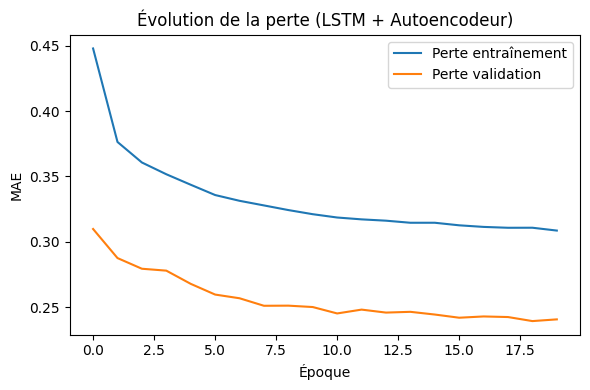

In [ ]:
# =========================
# ETAPE 4 — Entraînement du modèle CNN + AE
# =========================
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

val_split = 0.1
n_val = int(len(X_train) * val_split)
X_train_sub = X_train[:-n_val]
X_val_sub   = X_train[-n_val:]

print(f"Entraînement sur {len(X_train_sub)} fenêtres, validation sur {len(X_val_sub)}.")

history = model.fit(
    X_train_sub, X_train_sub,
    epochs=20,
    batch_size=64,
    SHUFFLE=False,
    validation_data=(X_val_sub, X_val_sub),
    callbacks=[es],
    verbose=1
)

# --- Courbe de perte ---
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Perte entraînement")
plt.plot(history.history["val_loss"], label="Perte validation")
plt.xlabel("Époque")
plt.ylabel("MAE")
plt.legend()
plt.title("Évolution de la perte (CNN + Autoencodeur)")
plt.tight_layout()
plt.show()

In [ ]:
# =========================
# ETAPE 5a — Reconstruction + erreur point-par-point
# =========================
import numpy as np
import pandas as pd

pred_all = model.predict(X_all, verbose=0).squeeze(-1)
n = len(df)

recon_sum   = np.zeros(n)
recon_count = np.zeros(n)
for w in range(pred_all.shape[0]):
    start = w
    end   = w + SEQ_LEN
    recon_sum[start:end]   += pred_all[w]
    recon_count[start:end] += 1

recon = np.full(n, np.nan)
mask_valid = recon_count > 0
recon[mask_valid] = recon_sum[mask_valid] / recon_count[mask_valid]

try:
    recon_value = scaler.inverse_transform(recon.reshape(-1,1)).ravel()
    orig_value  = df[VALUE_COL].to_numpy()
except Exception:
    recon_value = recon
    orig_value  = df["x"].to_numpy()

# 3) Erreur pointwise + lissage
df["recon"]      = recon_value
df["abs_err"]    = np.abs(orig_value - recon_value)
df.loc[:SEQ_LEN-2, "abs_err"] = np.nan

WIN = 7
df["err_smooth"] = (
    df["abs_err"]
    .rolling(WIN, center=True, min_periods=1).median()
    .rolling(WIN, center=True, min_periods=1).mean()
)

valid_pts = df["err_smooth"].notna().sum()
print(f"Reconstruction OK. Points valides pour l'erreur lissée : {valid_pts}/{len(df)}")
display(df[[TIME_COL, VALUE_COL, "recon", "abs_err", "err_smooth"]].head(10))

Reconstruction OK. Points valides pour l'erreur lissée : 15823/15831


,timestamp,value,recon,abs_err,err_smooth
0,2015-02-26 21:42:53,57,60.241919,NaN,NaN
1,2015-02-26 21:47:53,43,57.805512,NaN,NaN
2,2015-02-26 21:52:53,55,61.947858,NaN,NaN
3,2015-02-26 21:57:53,64,75.029245,NaN,NaN
4,2015-02-26 22:02:53,93,94.725518,NaN,NaN
5,2015-02-26 22:07:53,104,103.968267,NaN,NaN
6,2015-02-26 22:12:53,89,97.819843,NaN,NaN
7,2015-02-26 22:17:53,87,85.536318,NaN,NaN
8,2015-02-26 22:22:53,57,74.206807,NaN,3.614007
9,2015-02-26 22:27:53,68,68.073628,NaN,2.782668


Erreur calculée pour 15823/15831 points.


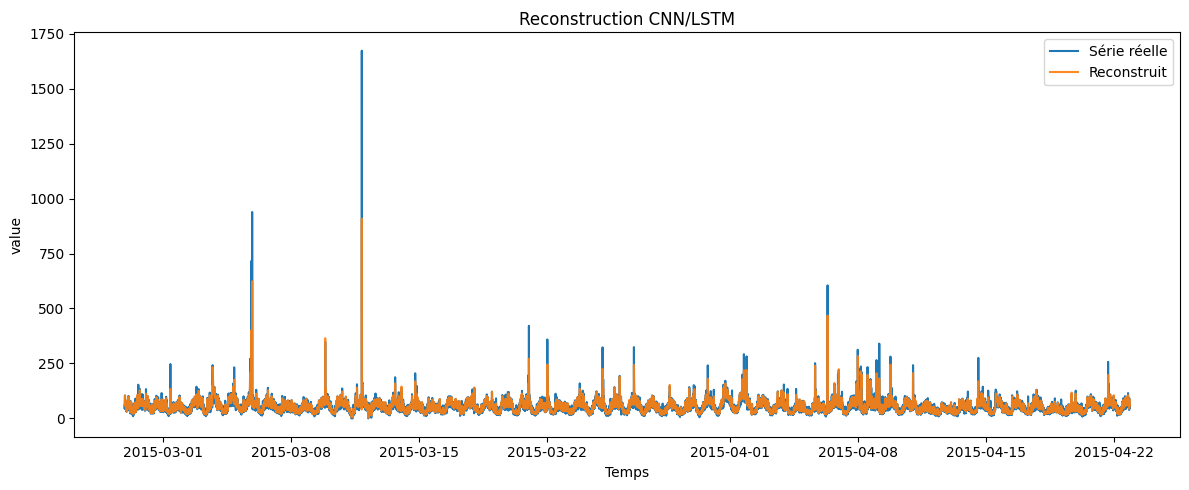

In [ ]:
# =========================
# ETAPE 5 — Reconstruction + erreur pointwise
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pred_all = model.predict(X_all, verbose=0).squeeze(-1)

n = len(df)
recon_sum   = np.zeros(n)
recon_count = np.zeros(n)

for w in range(pred_all.shape[0]):
    start = w
    end   = w + SEQ_LEN
    recon_sum[start:end]   += pred_all[w]
    recon_count[start:end] += 1

recon = np.full(n, np.nan)
mask = recon_count > 0
recon[mask] = recon_sum[mask] / recon_count[mask]

try:
    recon_value = scaler.inverse_transform(recon.reshape(-1,1)).ravel()
    orig_value  = df[VALUE_COL].to_numpy()
except:
    recon_value = recon
    orig_value  = df.get("x", df[VALUE_COL]).to_numpy()

df["recon"]   = recon_value
df["abs_err"] = np.abs(orig_value - recon_value)


df.loc[:SEQ_LEN-2, "abs_err"] = np.nan

WIN = 7
df["err_smooth"] = (
    df["abs_err"]
      .rolling(WIN, center=True, min_periods=1).median()
      .rolling(WIN, center=True, min_periods=1).mean()
)

print(f"Erreur calculée pour {df['err_smooth'].notna().sum()}/{len(df)} points.")

def plot_reconstruction(start=None, end=None, title="Reconstruction CNN"):
    ts  = df[TIME_COL]
    ori = orig_value
    rec = recon_value

    mask = np.ones(len(df), dtype=bool)
    if start: mask &= (ts >= pd.to_datetime(start))
    if end:   mask &= (ts <= pd.to_datetime(end))

    plt.figure(figsize=(12,5))
    plt.plot(ts[mask], ori[mask], label="Série réelle")
    plt.plot(ts[mask], rec[mask], label="Reconstruit", alpha=0.9)

    if "true_intervals" in globals():
        once = True
        for s,e in true_intervals:
            if s <= ts[mask].iloc[-1] and e >= ts[mask].iloc[0]:
                plt.axvspan(s, e, alpha=0.15, color="red",
                            label="NAB" if once else None)
                once = False

    plt.title(title)
    plt.xlabel("Temps")
    plt.ylabel(VALUE_COL)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
plot_reconstruction()

In [ ]:
def flags_to_intervals(flags, dates):
    """Transforme un vecteur booléen (flags) en liste d'intervalles [start, end]"""
    ints = []
    on = False
    start = None
    for i in range(1, len(flags)):
        if flags[i] and not flags[i-1]:
            on = True
            start = dates.iloc[i]
        if not flags[i] and flags[i-1]:
            on = False
            ints.append((start, dates.iloc[i]))
    if on:
        ints.append((start, dates.iloc[-1]))
    return ints

Seuil adaptatif par heure (q=0.99, FACTOR=1.1)
- TP=184  FP=1  FN=1396  TN=14250
Precision=0.995 | Recall=0.116 | F1=0.208


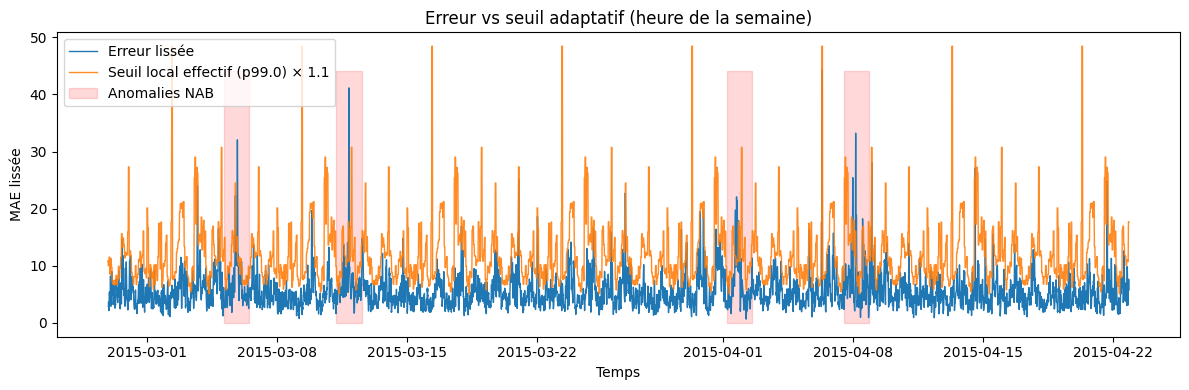

In [ ]:
# ===== 5b' — Seuil adaptatif par heure de la semaine =====
import numpy as np
import matplotlib.pyplot as plt

df["hour_of_week"] = df[TIME_COL].dt.dayofweek * 24 + df[TIME_COL].dt.hour

valid_mask = df["err_smooth"].notna().values
normal_mask_points = (df["label"].values == 0) & valid_mask

q = 0.99
thr_map = (
    df.loc[normal_mask_points, ["hour_of_week", "err_smooth"]]
      .groupby("hour_of_week")["err_smooth"]
      .quantile(q)
)

# Appliquer le seuil correspondant à l'heure de chaque point
df["thr_local"] = df["hour_of_week"].map(thr_map).astype(float).values

df["thr_local"] = df["thr_local"].rolling(3, center=True, min_periods=1).mean()

FACTOR = 1.10
thr_eff = FACTOR * df["thr_local"].to_numpy()

err = df["err_smooth"].to_numpy()
pred = np.zeros(len(df), dtype=bool)
pred[valid_mask] = err[valid_mask] > thr_eff[valid_mask]

df["pred_point"] = pred.astype(int)

y_true = (df["label"].values == 1) & valid_mask
y_pred = pred & valid_mask

TP = int(np.sum(y_pred & y_true))
FP = int(np.sum(y_pred & ~y_true))
FN = int(np.sum(~y_pred & y_true))
TN = int(np.sum(~y_pred & ~y_true))

precision = TP / (TP + FP + 1e-12)
recall    = TP / (TP + FN + 1e-12)
f1        = 2*precision*recall / (precision + recall + 1e-12)

print(f"Seuil adaptatif par heure (q={q}, FACTOR={FACTOR})")
print(f"- TP={TP}  FP={FP}  FN={FN}  TN={TN}")
print(f"Precision={precision:.3f} | Recall={recall:.3f} | F1={f1:.3f}")

plt.figure(figsize=(12,4))
plt.plot(df[TIME_COL], df["err_smooth"], lw=1, label="Erreur lissée")
plt.plot(df[TIME_COL], thr_eff, lw=1, alpha=0.9,
         label = f"Seuil local effectif (p{int(q*1000)/10}) × {FACTOR}")

ymax = np.nanmax(df["err_smooth"].values)
is_anom = (df["label"].values == 1)

plt.fill_between(
    df[TIME_COL],
    0,
    ymax,
    where=is_anom,
    alpha=0.15,
    color="red",
    label="Anomalies NAB"
)

plt.title("Erreur vs seuil adaptatif (heure de la semaine)")
plt.xlabel("Temps"); plt.ylabel("MAE lissée")
plt.legend(loc="upper left"); plt.tight_layout()
plt.show()

Seuil adaptatif par heure (q=0.999, FACTOR=1.09)
- TP=1105  FP=113  FN=475  TN=14138
Precision=0.907 | Recall=0.699 | F1=0.790


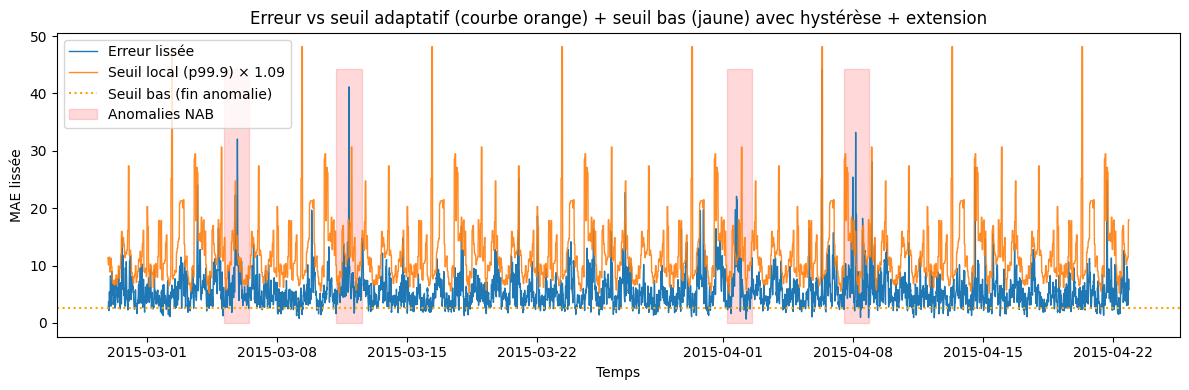

In [ ]:
# ===== 5b' — Seuil adaptatif par heure de la semaine + HYSTÉRÈSE SIMPLE =====
import numpy as np
import matplotlib.pyplot as plt

df["hour_of_week"] = df[TIME_COL].dt.dayofweek * 24 + df[TIME_COL].dt.hour

valid_mask = df["err_smooth"].notna().values
normal_mask_points = (df["label"].values == 0) & valid_mask

q = 0.999
thr_map = (
    df.loc[normal_mask_points, ["hour_of_week", "err_smooth"]]
      .groupby("hour_of_week")["err_smooth"]
      .quantile(q)
)

df["thr_local"] = df["hour_of_week"].map(thr_map).astype(float).values
df["thr_local"] = df["thr_local"].rolling(3, center=True, min_periods=1).mean()

FACTOR = 1.09
thr_eff = FACTOR * df["thr_local"].to_numpy()

seuil_bas = np.nanmean(thr_eff) * 0.21

err = df["err_smooth"].to_numpy()

flags = np.zeros(len(df), dtype=bool)
en_anomalie = False

for i in range(len(df)):
    if not valid_mask[i]:
        continue

    if not en_anomalie:
        if err[i] > thr_eff[i]:
            en_anomalie = True
            flags[i] = True
    else:
        if err[i] > seuil_bas:
            flags[i] = True
        else:
            en_anomalie = False

L_before = 15
L_after  = 7

flags_ext = np.zeros_like(flags)
in_seg = False
start = None

for i in range(len(flags)):
    if flags[i] and not in_seg:
        in_seg = True
        start = i
    if (not flags[i] and in_seg) or (i == len(flags)-1 and in_seg):
        end = i if not flags[i] else i
        s_ext = max(0, start - L_before)
        e_ext = min(len(flags) - 1, end + L_after)
        flags_ext[s_ext:e_ext+1] = True
        in_seg = False

flags = flags_ext

df["pred_point"] = flags.astype(int)

y_true = (df["label"].values == 1) & valid_mask
y_pred = flags & valid_mask

TP = int(np.sum(y_pred & y_true))
FP = int(np.sum(y_pred & ~y_true))
FN = int(np.sum(~y_pred & y_true))
TN = int(np.sum(~y_pred & ~y_true))

precision = TP / (TP + FP + 1e-12)
recall    = TP / (TP + FN + 1e-12)
f1        = 2 * precision * recall / (precision + recall + 1e-12)

print(f"Seuil adaptatif par heure (q={q}, FACTOR={FACTOR})")
print(f"- TP={TP}  FP={FP}  FN={FN}  TN={TN}")
print(f"Precision={precision:.3f} | Recall={recall:.3f} | F1={f1:.3f}")

plt.figure(figsize=(12,4))
plt.plot(df[TIME_COL], df["err_smooth"], lw=1, label="Erreur lissée")

plt.plot(
    df[TIME_COL],
    thr_eff,
    lw=1,
    alpha=0.9,
    label=f'Seuil local (p{int(q*1000)/10}) × {FACTOR}'
)

plt.axhline(
    y=seuil_bas,
    color="orange",
    linestyle=":",
    label="Seuil bas (fin anomalie)"
)

ymax = np.nanmax(df["err_smooth"].values)
is_anom = (df["label"].values == 1)

plt.fill_between(
    df[TIME_COL],
    0,
    ymax,
    where=is_anom,
    alpha=0.15,
    color="red",
    label="Anomalies NAB"
)

plt.title("Erreur vs seuil adaptatif (courbe orange) + seuil bas (jaune) avec hystérèse + extension")
plt.xlabel("Temps"); plt.ylabel("MAE lissée")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

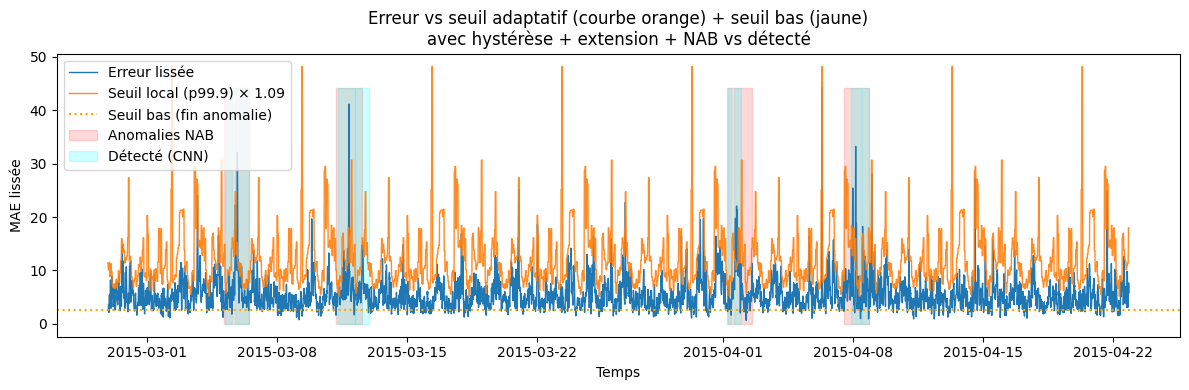

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(df[TIME_COL], df["err_smooth"], lw=1, label="Erreur lissée")

plt.plot(
    df[TIME_COL],
    thr_eff,
    lw=1,
    alpha=0.9,
    label=f'Seuil local (p{int(q*1000)/10}) × {FACTOR}'
)

plt.axhline(
    y=seuil_bas,
    color="orange",
    linestyle=":",
    label="Seuil bas (fin anomalie)"
)

ymax = np.nanmax(df["err_smooth"].values)

is_anom_nab = (df["label"].values == 1)

plt.fill_between(
    df[TIME_COL],
    0,
    ymax,
    where=is_anom_nab,
    alpha=0.15,
    color="red",
    label="Anomalies NAB"
)

is_detected = flags & valid_mask

plt.fill_between(
    df[TIME_COL],
    0,
    ymax,
    where=is_detected,
    alpha=0.20,
    color="cyan",
    label="Détecté (CNN)"
)

plt.title("Erreur vs seuil adaptatif (courbe orange) + seuil bas (jaune)\navec hystérèse + extension + NAB vs détecté")
plt.xlabel("Temps"); plt.ylabel("MAE lissée")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd, numpy as np, requests
from sklearn.preprocessing import StandardScaler

category = "realTweets"
fname    = "Twitter_volume_FB.csv"

# 1) Charger la série depuis GitHub
raw_csv = f"https://raw.githubusercontent.com/numenta/NAB/master/data/{category}/{fname}"
df = pd.read_csv(raw_csv)

# Détecter les colonnes temps / valeur
time_candidates  = [c for c in df.columns if "time" in c.lower() or "date" in c.lower()]
if not time_candidates:
    raise ValueError("Impossible de trouver la colonne temps (contient 'time' ou 'date').")
TIME_COL = time_candidates[0]
value_candidates = [c for c in df.columns if c != TIME_COL and df[c].dtype != "object"]
if not value_candidates:
    for c in df.columns:
        if c != TIME_COL:
            df[c] = pd.to_numeric(df[c], errors="coerce")
            if df[c].notna().any():
                value_candidates = [c]; break
if not value_candidates:
    raise ValueError("Impossible de trouver la colonne valeur.")
VALUE_COL = value_candidates[0]

df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df = df[[TIME_COL, VALUE_COL]].dropna().sort_values(TIME_COL).reset_index(drop=True)

# 2) Charger les fenêtres d'anomalies (ground-truth NAB)
labels_url = "https://raw.githubusercontent.com/numenta/NAB/master/labels/combined_windows.json"
windows = requests.get(labels_url).json()
key = f"{category}/{fname}"
win_list = windows.get(key, [])

ts = df[TIME_COL].to_numpy()
labels_points = np.zeros(len(df), dtype=bool)

for w in win_list:
    if isinstance(w, dict):
        s = pd.to_datetime(w["start"]); e = pd.to_datetime(w["end"])
    elif isinstance(w, (list, tuple)) and len(w) >= 2:
        s = pd.to_datetime(w[0]); e = pd.to_datetime(w[1])
    else:
        continue
    labels_points |= (ts >= s) & (ts <= e)

df["label"] = labels_points.astype(int)

scaler = StandardScaler().fit(df.loc[df["label"]==0, [VALUE_COL]])
df["x"] = scaler.transform(df[[VALUE_COL]])

n_total = len(df)
n_anom  = int(df["label"].sum())
print(f"Série chargée: {key}")
print(f"Période: {df[TIME_COL].min()} -> {df[TIME_COL].max()} | n={n_total}")
print(f"Fenêtres NAB: {len(win_list)} | Points anormaux (NAB): {n_anom}")
display(df.head())

Série chargée: realTweets/Twitter_volume_FB.csv
Période: 2015-02-26 21:42:53 -> 2015-04-22 21:02:53 | n=15833
Fenêtres NAB: 2 | Points anormaux (NAB): 1582


,timestamp,value,label,x
0,2015-02-26 21:42:53,53,0,2.225750
1,2015-02-26 21:47:53,64,0,2.920784
2,2015-02-26 21:52:53,49,0,1.973010
3,2015-02-26 21:57:53,48,0,1.909825
4,2015-02-26 22:02:53,22,0,0.267016


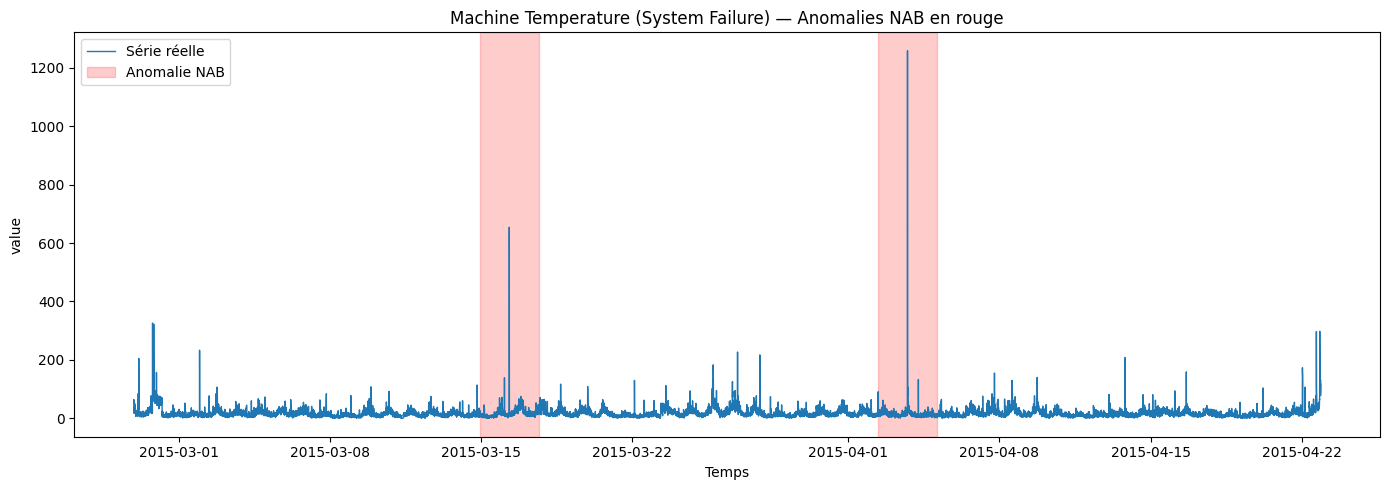

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1) Charger les fenêtres d'anomalies NAB pour cette série
true_ints = load_anomaly_windows_for(
    "realTweets/Twitter_volume_FB.csv"
)

plt.figure(figsize=(14, 5))
ts = df[TIME_COL]
vals = df[VALUE_COL]

plt.plot(ts, vals, lw=1, label="Série réelle")

first = True
for start, end in true_ints:
    plt.axvspan(start, end,
                color="red", alpha=0.2,
                label="Anomalie NAB" if first else None)
    first = False

plt.title("TWitter_FB — Anomalies NAB en rouge")
plt.xlabel("Temps")
plt.ylabel(VALUE_COL)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# reshape pour scaler : (N, 1)
values = df["value"].values.reshape(-1, 1)

values_scaled = scaler.fit_transform(values)

df["value_scaled"] = values_scaled

In [ ]:
signal = df["value_scaled"].values

In [ ]:
df["x"] = scaler.transform(df[[VALUE_COL]])

X_new_all = to_windows(df["x"], SEQ_LEN)

print("len(df) :", len(df))
print("X_new_all shape :", X_new_all.shape)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


len(df) : 15833
X_new_all shape : (15818, 15, 1)


In [ ]:
# =========================
# Reconstruction + erreur sur la nouvelle série (FB)
# =========================
pred_new = model.predict(X_new_all, verbose=0).squeeze(-1)

n_new = len(df)
recon_sum   = np.zeros(n_new)
recon_count = np.zeros(n_new)

for w in range(pred_new.shape[0]):
    start = w
    end   = w + SEQ_LEN
    recon_sum[start:end]   += pred_new[w]
    recon_count[start:end] += 1

valid_mask_new = recon_count > 0
recon_new = np.full(n_new, np.nan)
recon_new[valid_mask_new] = recon_sum[valid_mask_new] / recon_count[valid_mask_new]

# revenir à l’échelle d’origine
try:
    recon_value_new    = scaler.inverse_transform(recon_new.reshape(-1,1)).ravel()
    original_value_new = df[VALUE_COL].to_numpy()
except Exception:
    recon_value_new    = recon_new
    original_value_new = df[VALUE_COL].to_numpy()

abs_err_new = np.abs(original_value_new - recon_value_new)
df["recon"]      = recon_value_new
df["abs_err"]    = abs_err_new

WIN = 15
df["err_smooth"] = (
    df["abs_err"]
      .rolling(WIN, center=True, min_periods=1).median()
      .rolling(WIN, center=True, min_periods=1).mean()
)

print("Reconstruction terminée sur la nouvelle série.")
print(df[[TIME_COL, VALUE_COL, "recon", "abs_err", "err_smooth"]].head())

Reconstruction terminée sur la nouvelle série.
            timestamp  value      recon    abs_err  err_smooth
0 2015-02-26 21:42:53     53  48.454179   4.545821    6.140366
1 2015-02-26 21:47:53     64  52.063894  11.936106    6.116513
2 2015-02-26 21:52:53     49  47.771057   1.228943    6.068927
3 2015-02-26 21:57:53     48  38.149050   9.850950    6.029992
4 2015-02-26 22:02:53     22  26.414715   4.414715    5.974134


In [ ]:
df.columns
df.head()

,timestamp,value,label,x,value_scaled,recon,abs_err,err_smooth,hour_of_week,thr_local,pred_point
0,2015-02-26 21:42:53,53,0,1.782661,1.782661,48.454179,4.545821,6.140366,93,8.394878,0
1,2015-02-26 21:47:53,64,0,2.339921,2.339921,52.063894,11.936106,6.116513,93,8.394878,0
2,2015-02-26 21:52:53,49,0,1.580021,1.580021,47.771057,1.228943,6.068927,93,8.394878,0
3,2015-02-26 21:57:53,48,0,1.529361,1.529361,38.149050,9.850950,6.029992,93,7.675641,0
4,2015-02-26 22:02:53,22,0,0.212201,0.212201,26.414715,4.414715,5.974134,94,6.956404,0


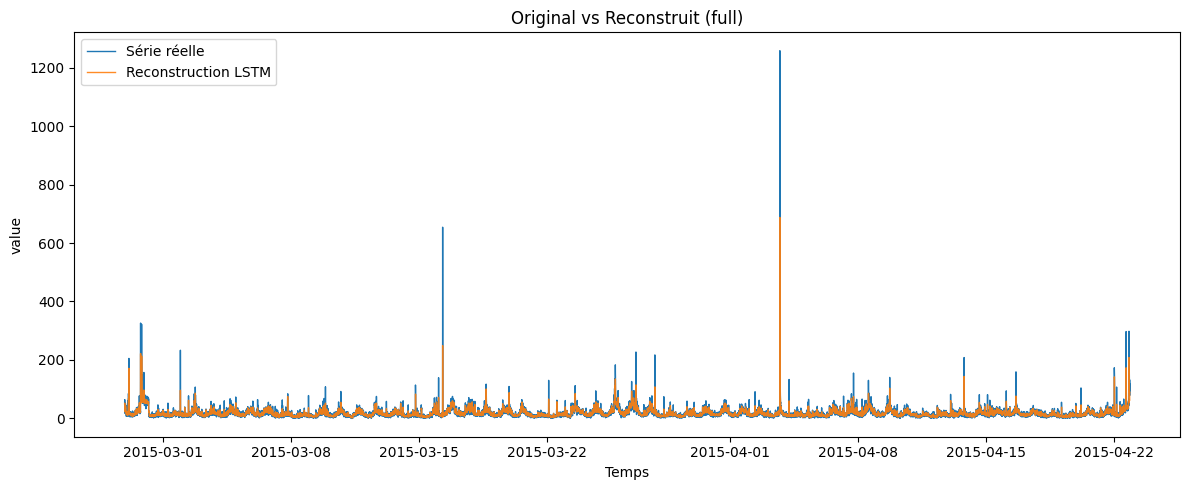

In [ ]:
# ===============================
# Reconstruction CNN
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_reconstruction_mt(start=None, end=None, title_suffix="(full)"):
    ts        = df[TIME_COL]
    orig_val  = df[VALUE_COL].to_numpy()
    recon_val = df["recon"].to_numpy()

    mask = np.ones(len(df), dtype=bool)
    if start is not None:
        mask &= (ts >= pd.to_datetime(start))
    if end is not None:
        mask &= (ts <= pd.to_datetime(end))

    plt.figure(figsize=(12,5))
    plt.plot(ts[mask], orig_val[mask],  lw=1, label="Série réelle")
    plt.plot(ts[mask], recon_val[mask], lw=1, alpha=0.9, label="Reconstruction CNN")
    plt.title(f"Original vs Reconstruit {title_suffix}")
    plt.xlabel("Temps")
    plt.ylabel(VALUE_COL)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

plot_reconstruction_mt()

Seuil adaptatif par heure (q=0.98, FACTOR=1.1)
- TP=1028  FP=87  FN=554  TN=14164
Precision=0.922 | Recall=0.650 | F1=0.762


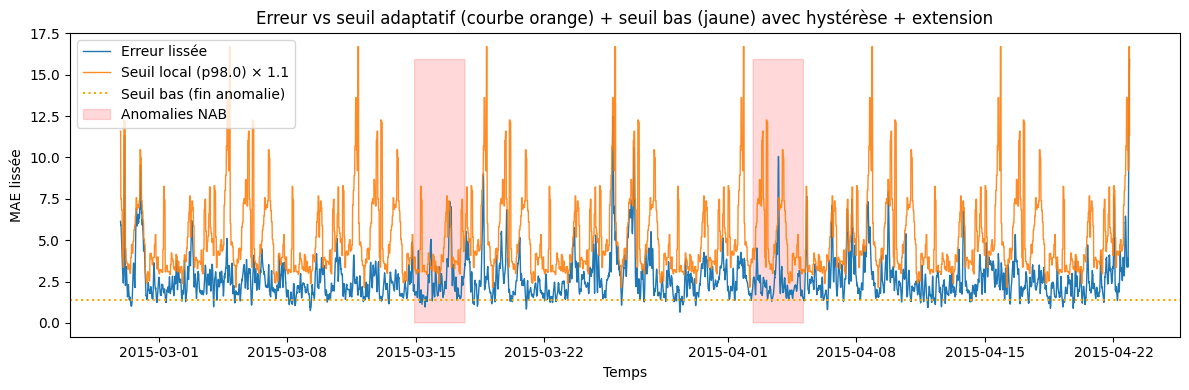

In [ ]:
# =====  Seuil adaptatif par heure de la semaine + HYSTÉRÈSE SIMPLE =====
import numpy as np
import matplotlib.pyplot as plt

df["hour_of_week"] = df[TIME_COL].dt.dayofweek * 24 + df[TIME_COL].dt.hour

valid_mask = df["err_smooth"].notna().values
normal_mask_points = (df["label"].values == 0) & valid_mask

# 1) Seuil local: quantile de l'erreur NORMALE pour chaque heure de la semaine
q = 0.98
thr_map = (
    df.loc[normal_mask_points, ["hour_of_week", "err_smooth"]]
      .groupby("hour_of_week")["err_smooth"]
      .quantile(q)
)

df["thr_local"] = df["hour_of_week"].map(thr_map).astype(float).values
df["thr_local"] = df["thr_local"].rolling(3, center=True, min_periods=1).mean()

FACTOR = 1.10
thr_eff = FACTOR * df["thr_local"].to_numpy()

seuil_bas = np.nanmean(thr_eff) * 0.27
err = df["err_smooth"].to_numpy()

flags = np.zeros(len(df), dtype=bool)
en_anomalie = False

for i in range(len(df)):
    if not valid_mask[i]:
        continue

    if not en_anomalie:
        if err[i] > thr_eff[i]:
            en_anomalie = True
            flags[i] = True
    else:
        if err[i] > seuil_bas:
            flags[i] = True
        else:
            en_anomalie = False

L_before = 60
L_after  = 15

flags_ext = np.zeros_like(flags)
in_seg = False
start = None

for i in range(len(flags)):
    if flags[i] and not in_seg:
        in_seg = True
        start = i
    if (not flags[i] and in_seg) or (i == len(flags)-1 and in_seg):
        end = i if not flags[i] else i
        s_ext = max(0, start - L_before)
        e_ext = min(len(flags) - 1, end + L_after)
        flags_ext[s_ext:e_ext+1] = True
        in_seg = False

flags = flags_ext

df["pred_point"] = flags.astype(int)
y_true = (df["label"].values == 1) & valid_mask
y_pred = flags & valid_mask

TP = int(np.sum(y_pred & y_true))
FP = int(np.sum(y_pred & ~y_true))
FN = int(np.sum(~y_pred & y_true))
TN = int(np.sum(~y_pred & ~y_true))

precision = TP / (TP + FP + 1e-12)
recall    = TP / (TP + FN + 1e-12)
f1        = 2 * precision * recall / (precision + recall + 1e-12)

print(f"Seuil adaptatif par heure (q={q}, FACTOR={FACTOR})")
print(f"- TP={TP}  FP={FP}  FN={FN}  TN={TN}")
print(f"Precision={precision:.3f} | Recall={recall:.3f} | F1={f1:.3f}")


plt.figure(figsize=(12,4))
plt.plot(df[TIME_COL], df["err_smooth"], lw=1, label="Erreur lissée")

plt.plot(
    df[TIME_COL],
    thr_eff,
    lw=1,
    alpha=0.9,
    label=f'Seuil local (p{int(q*1000)/10}) × {FACTOR}'
)

plt.axhline(
    y=seuil_bas,
    color="orange",
    linestyle=":",
    label="Seuil bas (fin anomalie)"
)

ymax = np.nanmax(df["err_smooth"].values)
is_anom = (df["label"].values == 1)

plt.fill_between(
    df[TIME_COL],
    0,
    ymax,
    where=is_anom,
    alpha=0.15,
    color="red",
    label="Anomalies NAB"
)

plt.title("Erreur vs seuil adaptatif (courbe orange) + seuil bas (jaune) avec hystérèse + extension")
plt.xlabel("Temps"); plt.ylabel("MAE lissée")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

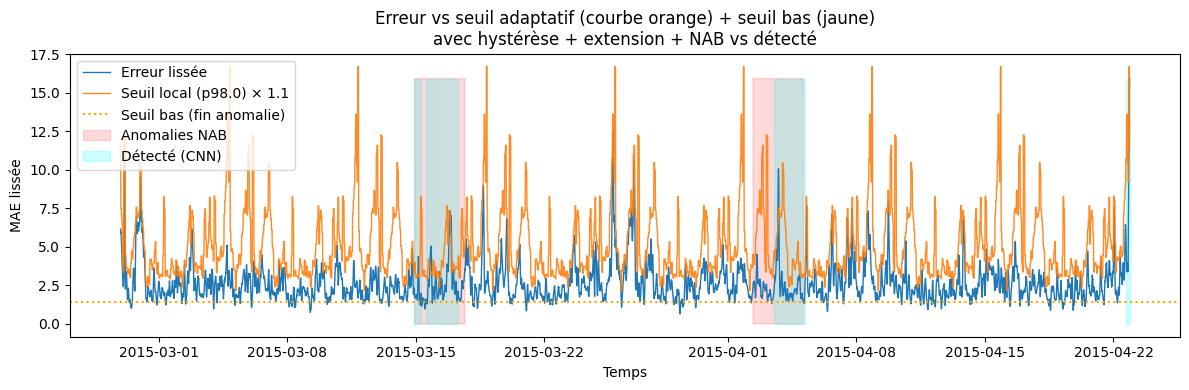

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(df[TIME_COL], df["err_smooth"], lw=1, label="Erreur lissée")

plt.plot(
    df[TIME_COL],
    thr_eff,
    lw=1,
    alpha=0.9,
    label=f'Seuil local (p{int(q*1000)/10}) × {FACTOR}'
)
plt.axhline(
    y=seuil_bas,
    color="orange",
    linestyle=":",
    label="Seuil bas (fin anomalie)"
)

ymax = np.nanmax(df["err_smooth"].values)

is_anom_nab = (df["label"].values == 1)

plt.fill_between(
    df[TIME_COL],
    0,
    ymax,
    where=is_anom_nab,
    alpha=0.15,
    color="red",
    label="Anomalies NAB"
)

is_detected = flags & valid_mask

plt.fill_between(
    df[TIME_COL],
    0,
    ymax,
    where=is_detected,
    alpha=0.20,
    color="cyan",
    label="Détecté (CNN)"
)

plt.title("Erreur vs seuil adaptatif (courbe orange) + seuil bas (jaune)\navec hystérèse + extension + NAB vs détecté")
plt.xlabel("Temps"); plt.ylabel("MAE lissée")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()